In [ ]:
!git clone https://github.com/adambielski/GrouPy.git
%cd GrouPy
!python setup.py install

Cloning into 'GrouPy'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 167 (delta 35), reused 33 (delta 33), pack-reused 119
Receiving objects: 100% (167/167), 141.59 KiB | 23.60 MiB/s, done.
Resolving deltas: 100% (75/75), done.
/content/GrouPy
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distut

La librería utiliza `np.int` el cual se encuentra deprecado desde la versión de NumPy 1.20, por ello el siguiente comando buscará todos los archivos `.py` en el directorio `/content/GrouPy/` y sus subdirectorios, y reemplazará `np.int` por `int` en cada uno de ellos.

In [ ]:
!find /content/GrouPy/ -type f -name "*.py" -exec sed -i 's/np.int/int/g' {} \;

In [ ]:
!find /content/GrouPy/ -type f -name "*.py" -exec sed -i 's/int64/np.int64/g' {} \;

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from groupy.gconv.pytorch_gconv.splitgconv2d import P4ConvZ2, P4ConvP4
from groupy.gconv.pytorch_gconv.pooling import plane_group_spatial_max_pooling

In [ ]:
#@title Parámetros de entrenamiento
batch_size = 64 #@param {type:"integer"}
test_batch_size = 1000 #@param {type:"integer"}
epochs = 10 #@param {type:"integer"}
lr = 0.01 #@param {type:"number"}
momentum = 0.5 #@param {type:"number"}
no_cuda = False #@param {type:"boolean"}
seed = 1 #@param {type:"integer"}
log_interval = 10 #@param {type:"integer"}

In [ ]:
cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# Normal CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

cnn_model = CNN()
if cuda:
    cnn_model.cuda()

cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=momentum)

def train_cnn(epoch):
    cnn_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        cnn_optimizer.zero_grad()
        output = cnn_model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        cnn_optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_cnn():
    cnn_model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = cnn_model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

for epoch in range(1, epochs + 1):
    train_cnn(epoch)
    test_cnn()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337452
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.311832
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.279203
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.227729
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.160804
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.187191
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.084965
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.015035
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.932347
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.855962
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.795808
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.638561
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.344617
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.359733
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.483898
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.046209
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.184519
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.189367
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.124603
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.860410
Train Epoch: 1 [12800/60000 (

<ipython-input-9-d68b290776d8>:49: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 0.1707, Accuracy: 9484/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.241863
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.301276
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.342178
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.312930
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.520197
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.250910
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.361173
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.188650
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.272456
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.420281
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.229292
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.300120
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.295544
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.400306
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.251904
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.444427
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.257318
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.296358
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.251658
Train Epoch: 2 [12

# G-CNNs

In [ ]:
class GCNN(nn.Module):
    def __init__(self):
        super(GCNN, self).__init__()
        self.gconv1 = P4ConvZ2(1, 10, kernel_size=3)
        self.gconv2 = P4ConvP4(10, 10, kernel_size=3)
        self.gconv3 = P4ConvP4(10, 20, kernel_size=3)
        self.gconv4 = P4ConvP4(20, 20, kernel_size=3)
        self.fc1 = nn.Linear(4*4*20*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.gconv1(x))
        x = F.relu(self.gconv2(x))
        x = plane_group_spatial_max_pooling(x, 2, 2)
        x = F.relu(self.gconv3(x))
        x = F.relu(self.gconv4(x))
        x = plane_group_spatial_max_pooling(x, 2, 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

gcnn_model = GCNN()
if cuda:
    gcnn_model.cuda()

gcnn_optimizer = optim.SGD(gcnn_model.parameters(), lr=lr, momentum=momentum)

def train_gcnn(epoch):
    gcnn_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        gcnn_optimizer.zero_grad()
        output = gcnn_model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        gcnn_optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_gcnn():
    gcnn_model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = gcnn_model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

for epoch in range(1, epochs + 1):
    train_gcnn(epoch)
    test_gcnn()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299777
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.237629
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.159484
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.897234
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.427760
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.451052
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.073578
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.120262
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.636485
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.809066
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.526731
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.620555
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.527599
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.423007
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.443311
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.629895
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.488481
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.375658
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.582381
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.523640
Train Epoch: 1 [12800/60000 (

<ipython-input-8-1b09e4459419>:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0615, Accuracy: 9798/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.294660
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.196581
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.284650
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.120426
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.094427
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.092236
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.122009
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.189968
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.220566
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.055343
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.113446
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.267168
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.150966
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.103696
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.314854
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.045115
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.127974
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.202883
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.100960
Train Epoch: 2 [12

# Comparasion

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Selecciona una imagen aleatoria del conjunto de datos de prueba
dataiter = iter(test_loader)
images, labels = dataiter.__next__()
image = images[0].unsqueeze(0)
label = labels[0]

if cuda:
    image = image.cuda()

In [ ]:
# Pasa la imagen a través de la red
output = cnn_model(image)
_, predicted = torch.max(output, 1)

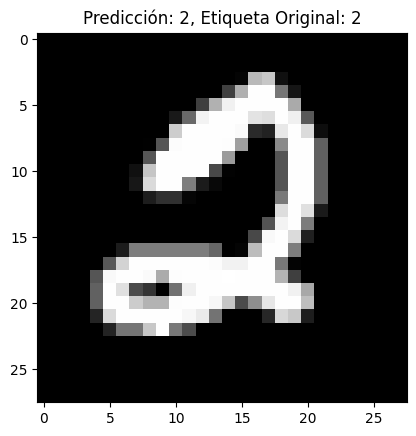

In [ ]:
# Muestra la imagen y la predicción
plt.imshow(images[0].numpy().squeeze(), cmap='gray')
plt.title(f'Predicción: {predicted.item()}, Etiqueta Original: {label.item()}')
plt.show()

In [ ]:
from torchvision import transforms

# Define las transformaciones
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),  # Espejo
    transforms.RandomRotation(45),  # Rotación aleatoria de ±45 grados
    # transforms.RandomAffine(0, translate=(0.25, 0.25)),  # Traslación aleatoria de ±10%
])

image_transformed = transform(image)

In [ ]:
# Pasa la imagen a través de la red
output = cnn_model(image_transformed)
_, predicted = torch.max(output, 1)

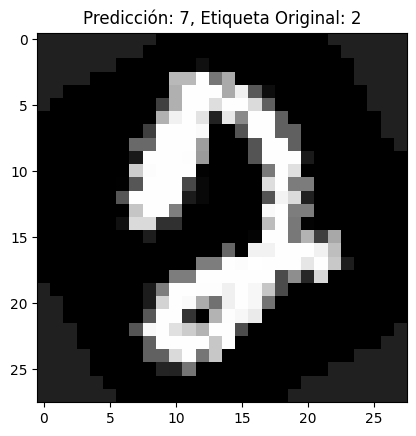

In [ ]:
# Muestra la imagen y la predicción
plt.imshow(image_transformed[0].cpu().numpy().squeeze(), cmap='gray')
plt.title(f'Predicción: {predicted.item()}, Etiqueta Original: {label.item()}')
plt.show()

In [ ]:
# Pasa la imagen a través de la red
output = gcnn_model(image_transformed)
_, predicted = torch.max(output, 1)

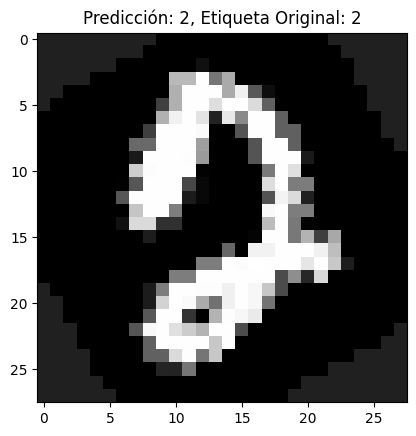

In [ ]:
# Muestra la imagen y la predicción
plt.imshow(image_transformed[0].cpu().numpy().squeeze(), cmap='gray')
plt.title(f'Predicción: {predicted.item()}, Etiqueta Original: {label.item()}')
plt.show()